# Financial Temporal Series Forecast

Version 2.0

This is the first version using Object Oriented concept to design the code...

That have only one class here yet, I'll keep working on it to improve the prediction accuracy and make it strongest and most robust agains the market intrinsically prices flutuations and volatility.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
from datetime import date

In [9]:
class ArimaAnalysis():  
    
    def __init__(self, complete_address, name):
        self._address = complete_address
        self._name = name  
        try:
            self._process_file = pd.read_csv(self._address, sep = ',', encoding = "latin1")
            print(f"Process Initializing...\nFile: {self._address}", end='\n\n')
            print(f"Columns founded:\n{self._process_file.columns}", end='\n\n')
            print("Important informations:")
            print(self._process_file.info(), end='\n\n')
            self._close_describe = self._process_file.Close.describe()
            print(f"Some fast describe:\n{self._close_describe}", end='\n\n')
            self._filelenght = int(self._close_describe[0])
            self._filemean = self._close_describe[1]
            self._filestd = self._close_describe[2]
        except:
            pass
          
    def getData(self, cp=True):
        def discreteDifferentiation(self, function_data, lenght, number):
            dfd_logreturn = []
            aux_var = 0
            try:
                for index in range(0, lenght-1):
                    aux_var = function_data[index+1] - function_data[index]
                    dfd_logreturn.append(aux_var)
            except:
                pass
            print(f"Created data array for function differentiation...\nFrom Close values of {self._name}")
            print(f'Process of differentiation number: {number}')
            print(f"Lenght: 1 x {len(dfd_logreturn)}", end='\n\n')
            return dfd_logreturn
        self._values_infoarray = self._process_file.Close.to_numpy(copy=cp)
        self._log_close_infoarray = self._process_file.Close.apply(np.log).to_numpy(copy=cp)
        self._log_returns = []
        self._dates_of_return = []
        self._firstdif_logreturn = []
        self._seconddif_logreturn = []
        log_value = 0
        for days in range(0, self._filelenght):
            try:
                if days == 0:
                    log_value = 0
                else:
                    log_value = self._log_close_infoarray[days] - self._log_close_infoarray[days-1]
            except:
                pass
            finally:
                    self._log_returns.append(log_value)
                    local_date = self._process_file.Date[days].split('-')
                    self._dates_of_return.append(date(int(local_date[0]), int(local_date[1]), int(local_date[2])))
        self._firstdif_logreturn = discreteDifferentiation(self, self._log_returns, self._filelenght, 1)
        self._seconddif_logreturn = discreteDifferentiation(self, self._firstdif_logreturn, self._filelenght-1, 2)
    
    def printData(self, save="None", title = ' ', xlabel = 'Data', ylabel = 'Relative Intensity'):
        plt.figure(figsize=(9, 3))
        plt.suptitle(title)
        if len(self._log_returns) == self._filelenght:
            plt.subplot(131)
            plt.plot([x for x in range(0,self._filelenght)], self._log_returns,
                         label="Function", linewidth=0.7, color='red')
            #plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.grid(True)
            plt.legend()
            plt.subplot(132)
            plt.plot([x for x in range(0,self._filelenght-1)], self._firstdif_logreturn,
                     label='First Dif', linewidth=0.7, color='blue')
            plt.xlabel(xlabel)
            #plt.ylabel(ylabel)
            plt.grid(True)
            plt.legend()
            plt.subplot(133)
            plt.plot([x for x in range(0,self._filelenght-2)], self._seconddif_logreturn,
                     label='Second Dif', linewidth=0.7, color='green')
            #plt.xlabel(xlabel)
            #plt.ylabel(ylabel)
            plt.grid(True)
            plt.legend()
            if save != 'None' and isinstance(save, str):
                save = save + '.png'
                plt.savefig(save)
                print(f"Figure save at: {save}")
            plt.show()
            print("Figure generated with no error...", end='\n\n')
    
    def checkSteady(self, begin):
        lenght = len(self._log_returns)
        x, std, mean = [], [], []
        start = int(begin*lenght)
        for days in range(start, lenght):
            x.append(days)
            std.append(np.std(self._log_returns[start:days]))
            mean.append(np.mean(self._log_returns[start:days]))
        plt.plot(x, std, linewidth=0.8, color='red')
        plt.plot(x, mean, linewidth=0.8, color='blue')
        plt.grid(True)
        plt.show()
        total = len(mean)
        print("Data storaged:", total, sep=' ')
        print("Steady Mean:", mean[total-1], "Steady STD:", std[total-1], sep='\n', end='\n\n')
    
    def generateCSV(self, file_name):
        dictionary = {'Dates': self._dates_of_return, 'LogReturn': self._log_returns, 'Value': self._values_infoarray}
        data_finance = pd.DataFrame(data=dictionary)
        dictionary.clear()
        print(f'New DataFrame created\n{data_finance.info()}',end='\n\n')
        print(data_finance.head(13), end='\n\n')
        data_string = data_finance.to_csv(index=False)
        try:
            with open(file_name,'w') as file:
                file.write(data_string)
            print(f'Data inputed successfully\nGenerated: {file_name} file')
        except IOError as ioerr:
            print(f'Error detected:\n{ioerr}')
            
    def to_ARIMA(self, train_size):
        lnr = self._log_returns.copy()
        lenght = len(lnr)
        truncate = int(train_size*lenght)
        arima_test, arima_train, data, predictions = [], [], [], []
        arima_train = [train_data for train_data in lnr[0:truncate]]
        arima_test = [test_data for test_data in lnr[truncate:lenght]]
        data = [data for data in arima_train]
        print("Total lenght:", lenght, sep=' ')
        print("Truncate point:", truncate, sep=' ')
        print("Creating Train set, lenght:", len(arima_train), sep=' ')
        print("Creating Test set, lenght:", len(arima_test), sep=' ')
        for time in range(0,lenght - truncate):
            model = ARIMA(data, order=(5, 1, 0))
            # ARIMA(p=5, q=1, i=0)
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            next_time = output[0]
            predictions.append(next_time)
            the_next_time = arima_test[time]
            data.append(the_next_time)
            if time == lenght-1:
                print(model_fit.summary())
                error = mean_squared_error(arima_test, predictions)
                print('Tested MSE:\n %.3f' % error)
        plt.plot(arima_test, linewidth = 1.0, color = 'green', label = 'Real Data')
        plt.plot(predictions, linewidth = 1.0, color='red', label = 'Expected Data')
        plt.legend()
        plt.grid(True)
        plt.title("ARIMA process")
        plt.show()

In [10]:
csv_data = str(input('Insert file:\n')).replace('\\','\\\\')
print(csv_data)

Insert file:
C:\Users\kgper\Downloads\MSFT (1).csv
C:\\Users\\kgper\\Downloads\\MSFT (1).csv


Process Initializing...
File: C:\\Users\\kgper\\Downloads\\MSFT (1).csv

Columns founded:
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

Important informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 7 columns):
Date         2265 non-null object
Open         2265 non-null float64
High         2265 non-null float64
Low          2265 non-null float64
Close        2265 non-null float64
Adj Close    2265 non-null float64
Volume       2265 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 123.9+ KB
None

Some fast describe:
count    2265.000000
mean       51.855347
std        27.263426
min        23.010000
25%        29.490000
50%        43.900002
75%        64.519997
max       130.600006
Name: Close, dtype: float64

Created data array for function differentiation...
From Close values of Data
Process of differentiation number: 1
Lenght: 1 x 2264

Created data array for function

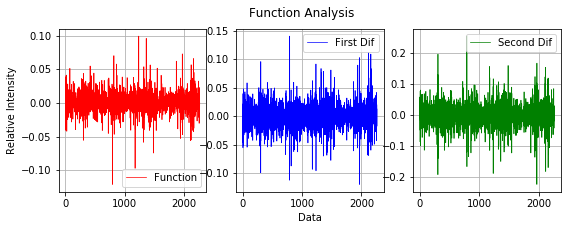

Figure generated with no error...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 3 columns):
Dates        2265 non-null object
LogReturn    2265 non-null float64
Value        2265 non-null float64
dtypes: float64(2), object(1)
memory usage: 53.2+ KB
New DataFrame created
None

         Dates  LogReturn      Value
0   2010-05-26   0.000000  25.010000
1   2010-05-27   0.038821  26.000000
2   2010-05-28  -0.007722  25.799999
3   2010-06-01   0.003482  25.889999
4   2010-06-02   0.021777  26.459999
5   2010-06-03   0.015004  26.860001
6   2010-06-04  -0.040651  25.790001
7   2010-06-07  -0.019578  25.290001
8   2010-06-08  -0.007143  25.110001
9   2010-06-09  -0.012826  24.790001
10  2010-06-10   0.008435  25.000000
11  2010-06-11   0.026058  25.660000
12  2010-06-14  -0.006255  25.500000

Data inputed successfully
Generated: Finance_data.txt file


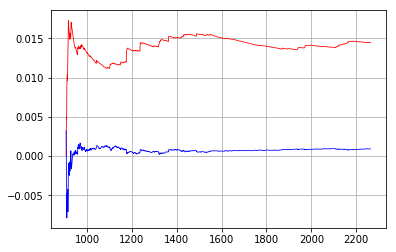

Data storaged: 1359
Steady Mean:
0.0008976319866974181
Steady STD:
0.014486510203914494

Total lenght: 2265
Truncate point: 1812
Creating Train set, lenght: 1812
Creating Test set, lenght: 453


C:\Users\kgper\Anaconda3\envs\DevAmb\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kgper\Anaconda3\envs\DevAmb\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kgper\Anaconda3\envs\DevAmb\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


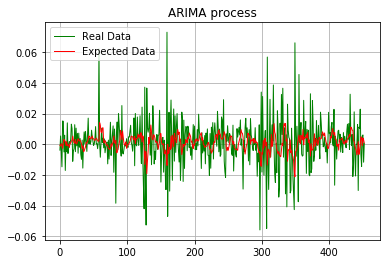

In [11]:
teste = ArimaAnalysis(csv_data, "Data")
teste.getData()
teste.printData(title='Function Analysis')
teste.generateCSV('Finance_data.txt')
teste.checkSteady(begin=0.4)
teste.to_ARIMA(train_size=0.8)